# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
clase = 3
root_dir = "/content/drive/My Drive/"
project_dir = "RRNN_PxQ/Clase_" + str(clase) + "/Práctica/"
os.chdir(root_dir + project_dir)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Dense, Conv1D, Flatten, concatenate, Input, LSTM, MaxPooling1D
from keras.utils import plot_model
from keras.models import Model

# API Model y bloques convolucionales

### API Model

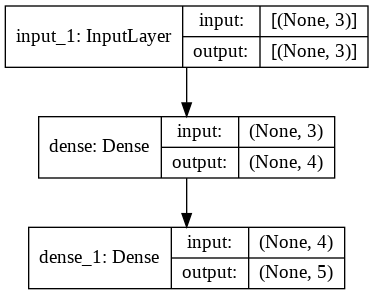

In [4]:
# https://keras.io/api/models/model/

# Vemos a continuación un ejemplo de un pequeño modelo de clasificación hecho con la API de Model

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile( 
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics = 'accuracy'
  )

tf.keras.utils.plot_model(model, show_shapes=True)

### Clase Model

También puede utilizarse directamente la clase Model (en vez de la API) para definir un modelo

La clase es como cualquier otra clase en python, y puede modificarse para incluír otras funciones

Se definen en el __init__ las capas y luego en el call se 'ordenan'.

In [ ]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.dense1(inputs)
    return self.dense2(x)

model = MyModel()

# https://keras.io/api/models/model/ 

Una vez inicializado se prosigue como siempre, compilándolo

Una diferencia es que tiene que estar entrenado primero para poder visualizarlo o hacerle .summary()  (salvo que el método summary se agregue a la clase)

In [ ]:
model.compile( 
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics = 'accuracy'
  )

### Capas varias con Model

Capas densas multi-input y distintos tratamientos:

La API de model (y la clase) nos permiten hacer redes que no sean secuenciales, llegando a arquitecturas mucho más complicadas.

Podemos por ejemplo crear una red que tome cuatro diferentes inputs, y a cada una le provea un tratamiento separado antes de combinarlas

In [5]:
#La idea es hacer una RN que tenga como input dos vectores distintos.
#creo capas de input para ambos
input1 = keras.Input(shape=(300,), name="input1")
input2 = keras.Input(shape=(48,), name="input2")
#creo capa para embeddings
dense_1 = layers.Dense(100, activation="tanh")
dense_100 = dense_1(input1)
#creo capa para sonidos
dense_2 = layers.Dense(100, activation="tanh")
dense_200 = dense_2(input2)

# Estas primeras capas también pueden definirse así:
#>>>  input1 = keras.Input(shape=(300,), name="input1")
#>>>  input2 = keras.Input(shape=(48,), name="input2")
#>>>  dense_1 = layers.Dense(100, activation="tanh")(input1)
#>>>  dense_2 = layers.Dense(100, activation="tanh")(input2)


#concateno
x = layers.concatenate([dense_100, dense_200])

#capa post concatenar
reduction_layer = layers.Dense(100, name="reduct", activation="tanh")(x)

#capa output
output = layers.Dense(9, name="output", activation="sigmoid")(reduction_layer)

#compilo el modelo
model = keras.Model(
    inputs=[input1, input2],
    outputs=output)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3), #optimizador con momentum
    loss=keras.losses.CategoricalCrossentropy(from_logits=True), #from_logits define si es un tensor de logits o si es un softmax
    metrics = ['f1_m']) #Se usa f1 porque este es un problema de clasificación


In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 300)]        0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 48)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          30100       input1[0][0]                     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          4900        input2[0][0]                     
____________________________________________________________________________________________

In [ ]:
model.fit( #Para llamar al fit se llaman a los inputs como un diccionario o como una lista directamente
    {"input1": X_train[input1], "input2": X_train[input2]},
    {"output": y_train},
    epochs=128,
    batch_size=100,
    validation_split=0.3 #Este validation split es solo para datos cross-sectional, OJO.
)

In [ ]:
y_pred_train = model.predict({"input1": X_test[input1], "input2": X_test[input2]})

### Funciones con redes y bloques convolucionales

Redes en funciones y bloques convolucionales:

Por ejemplo, tenemos el siguiente ejemplo de una función para construir una red entera:

In [24]:
def construir_modelo(n_layers, n_neurons, n_features, learning_rate): # Esta función construye una red que va haciéndose más y más chica hasta llegar a 9 clases
  model = keras.Sequential()
  for layer in range(n_layers):
    if layer == 0:
      model.add(layers.Dense(n_neurons, input_dim = n_features, activation='tanh'))
    elif layer ==1:
      model.add(layers.Dense(n_neurons, activation='tanh'))
    else:
      n_neurons = int(n_neurons/2)
      model.add(layers.Dense(n_neurons, activation='tanh'))
  model.add(layers.Dense(9, activation='sigmoid'))
  opt = keras.optimizers.Adam(learning_rate=learning_rate)  
  # model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return(model)

model = construir_modelo(5, 100, 20, 0.001)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_11 (Dense)             (None, 12)                312       
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 117       
Total params: 18,954
Trainable params: 18,954
Non-trainable params: 0
____________________________________________________

Podemos también construir bloques de un modelo, no necesariamente el modelo completo:

In [8]:
def bloque_conv_1d(layer_in, n_filters, ker1 = 5, ker2 = 1):
  layer = Conv1D(filters = n_filters, kernel_size = ker1, activation='relu', padding= 'valid')(layer_in)
  layer = Conv1D(filters = 2*n_filters, kernel_size = ker2, padding= 'same', activation='relu')(layer)
  return layer 

El Shape de la capa convolucional es (batch_size, cant_casos, largo_casos). Por ejemplo, si tenemos 10 vectores de largo 128 en cada caso, y para cada batch  tenemos 4 casos, sería (4, 10, 128).Para pasárselo a la capa convolucional solo nos importan las últimas 2.

Ver https://www.youtube.com/watch?v=WZdxt9xatrY&ab_channel=MuratKarakayaAkademi

Ver https://www.youtube.com/watch?v=JzoIHdkFcQU&t=324s&ab_channel=MuratKarakayaAkademi 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 8)             48        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 16)            144       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 8)             648       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 22, 16)            144       
_________________________________________________________________
dense_4 (Dense)              (None, 22, 10)            170       
Total params: 1,154
Trainable params: 1,154
Non-trainable params: 0
_________________________________________________________

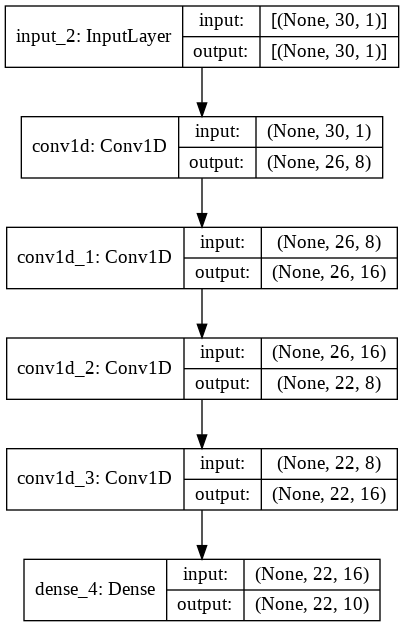

In [9]:
# Y después consturir un modelo a partir de eso:
input = Input(shape=(30,1))
bloque = bloque_conv_1d(input, 8)
bloque = bloque_conv_1d(bloque, 8)
output = Dense(10, activation='relu')(bloque)

# Creamos el modelo
model = Model(inputs=input, outputs=output)
# Hacemos un Summary
model.summary()
# Graficamos
plot_model(model, show_shapes=True)


### Capas LSTM 

Las capas LSTM funcionan de manera similar a todo lo anterior.

Pueden añadirse dentro de Model y de Sequential, son una capa más.

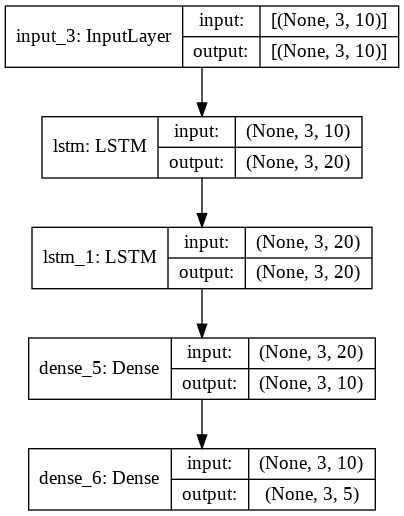

In [10]:
inputs = tf.keras.Input(shape=(3,10))
x = LSTM(20, return_sequences=True)(inputs)
x = LSTM(20, return_sequences= True)(x)
x = Dense(10, activation=tf.nn.softmax)(x)
outputs = Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile( 
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics = 'accuracy'
  )

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 10)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 2,745
Trainable params: 2,745
Non-trainable params: 0
_________________________________________________________________


Ver:

https://keras.io/api/layers/recurrent_layers/lstm/

https://www.youtube.com/watch?v=CcGf_Uo7NMw&ab_channel=KnowledgeCenter

# aplicación: Nitrógeno en el aire en Phoenix, Arizona


In [11]:
# Cargo los datos
dataset = "pollution_us_2000_2010_arizona_phoenix_sin_dif.csv"
dataset_path=os.path.join("datasets_clasificacion",dataset)
data=pd.read_csv(dataset_path, index_col = 0 )

print(f'El dataset cuenta con {len(data)} observaciones')

El dataset cuenta con 3857 observaciones


In [12]:
data = data.sort_values(by='Date Local').set_index('Date Local')
data.head()

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean
Date Local,,,,
2000-01-01,19.041667,0.022500,2.987500,1.012390
2000-01-02,34.583333,0.018833,4.603810,1.472917
2000-01-03,33.869565,0.017250,2.172050,0.985235
2000-01-04,26.833333,0.027792,1.063461,0.752084
2000-01-05,3.791667,0.033417,3.530357,1.272917


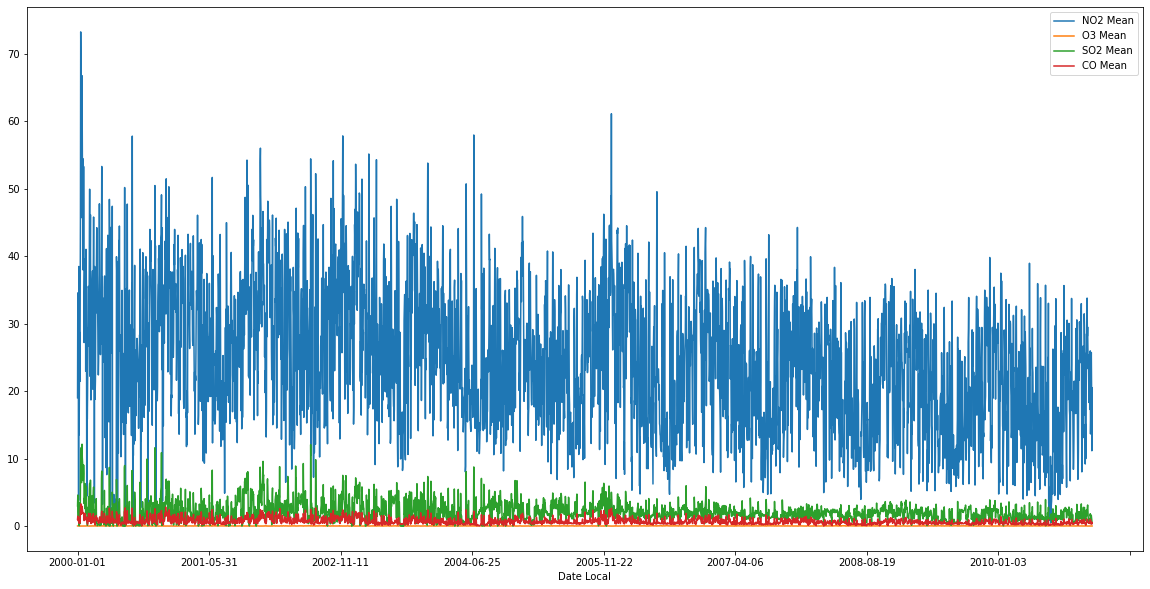

In [13]:
data.plot(subplots=False, figsize=(20, 10)); plt.legend(loc='best')

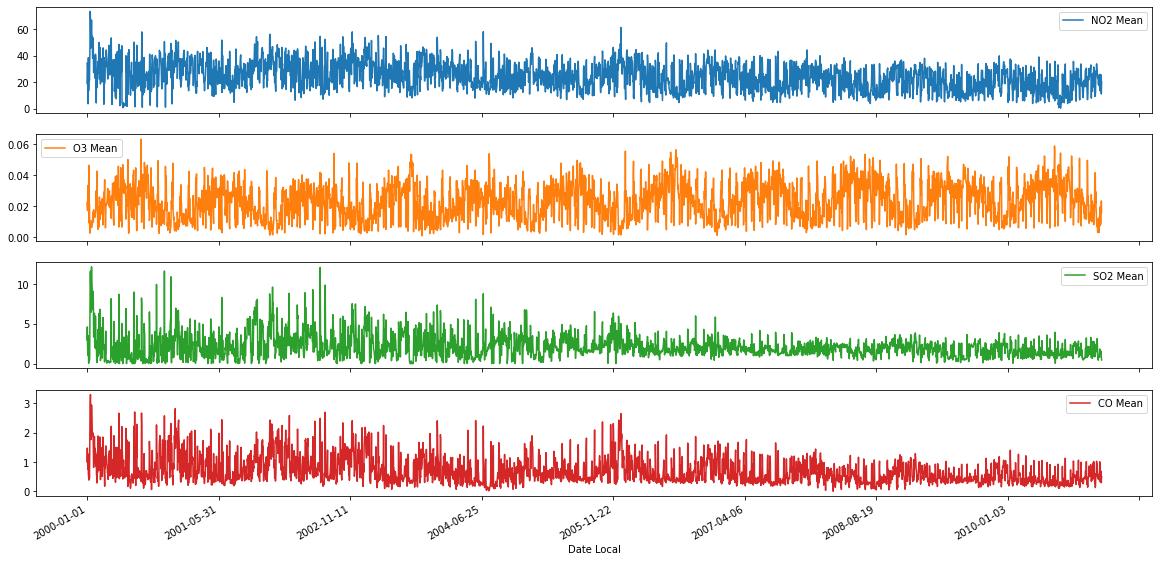

In [14]:
data.plot(subplots=True, figsize=(20, 10)); plt.legend(loc='best')

In [16]:
# Necesitamos primero tener en claro el objetivo: vamos a predecir

def df_to_train(data_obs, target_col, train_size, prediction_window, prediction_size):
  x_train = []
  y_train = []
  n_obs = len(data_obs)
  i=0
  while i < (n_obs-prediction_window-train_size-prediction_size):
    obs_x = data_obs[i:i+train_size].values
    obs_y = data_obs[target_col][i + train_size + prediction_window:i + train_size + prediction_window + prediction_size].values
    x_train.append(obs_x)
    y_train.append(obs_y)
    i += 1
  return np.array(x_train), np.array(y_train)


In [17]:
#  Primero vamos a hacer el train/test split:

porc_split = 0.7
index_split = int(np.floor(len(data)*0.7))

data_train = data[0:index_split]
data_test = data[index_split:]

# Centramos los datos:
media = data_train.mean()
desvio = data_train.std()

data_train = (data_train - media)/desvio
data_test = (data_test - media)/desvio  # OJO, estandarizo con la media y el std de TRAIN

print(f'Vector de medias train: {media} \n Vector de desvíos train: {desvio}')

Vector de medias train: NO2 Mean    26.495843
O3 Mean      0.022113
SO2 Mean     2.320954
CO Mean      0.783961
dtype: float64 
 Vector de desvíos train: NO2 Mean    10.288400
O3 Mean      0.010944
SO2 Mean     1.605432
CO Mean      0.491641
dtype: float64


In [18]:
print(f'Vector de medias train: \n {data_train.mean()} \n\n Vector de desvíos train: \n {data_train.std()}')

Vector de medias train: 
 NO2 Mean   -2.963173e-15
O3 Mean    -3.391960e-16
SO2 Mean    2.316002e-15
CO Mean     1.966646e-15
dtype: float64 

 Vector de desvíos train: 
 NO2 Mean    1.0
O3 Mean     1.0
SO2 Mean    1.0
CO Mean     1.0
dtype: float64


Coefficients: [-1.34270868e-07  7.37667412e-05 -9.80954759e-03  1.54267851e-01]


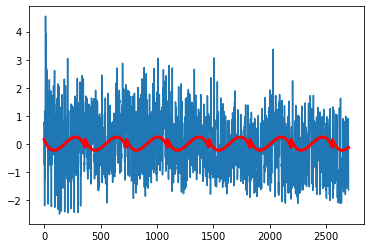

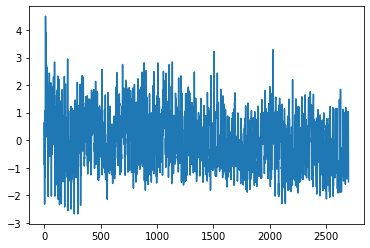

In [ ]:
# Podemos hacer un PolyFit también a train, a modo ejemplo lo muestro con NO2 Mean:
# Pueden encontrar el ejemplo en https://machinelearningmastery.com/time-series-seasonality-with-python/
from numpy import polyfit

degree = 3
X = [i%365 for i in range(0, len(data_train))]
y = data_train['NO2 Mean'].values
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(data_train)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# create seasonally adjusted
values = data_train['NO2 Mean'].values

plt.plot(y)
plt.plot(curve, color='red', linewidth=3)
plt.show()

diff = list()
for i in range(len(values)):
	value = values[i] - curve[i]
	diff.append(value)
plt.plot(diff)
plt.show()

In [19]:
x_train, y_train = df_to_train(data_obs = data_train, 
                             target_col = 'NO2 Mean', 
                             train_size = 40, 
                             prediction_window = 0, 
                             prediction_size = 10)

x_test, y_test = df_to_train(data_obs = data_test, 
                             target_col = 'NO2 Mean', 
                             train_size = 40, 
                             prediction_window = 0, 
                             prediction_size = 10)

In [20]:
data_train[0:10]

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean
Date Local,,,,
2000-01-01,-0.724522,0.035350,0.415181,0.464625
2000-01-02,0.786078,-0.299717,1.421957,1.401337
2000-01-03,0.716702,-0.444361,-0.092750,0.409393
2000-01-04,0.032803,0.518900,-0.783274,-0.064839
2000-01-05,-2.206774,1.032876,0.753319,0.994538
2000-01-06,1.166766,-0.200668,-0.055876,-0.378800
2000-01-07,-1.259105,0.838707,-1.418184,-0.603003
2000-01-08,-0.396483,2.213058,-1.318516,-0.814878
2000-01-09,0.216888,-1.179188,-0.397637,0.155511


In [21]:
data_train['NO2 Mean'][0:10]

Date Local
2000-01-01   -0.724522
2000-01-02    0.786078
2000-01-03    0.716702
2000-01-04    0.032803
2000-01-05   -2.206774
2000-01-06    1.166766
2000-01-07   -1.259105
2000-01-08   -0.396483
2000-01-09    0.216888
2000-01-10   -0.489630
Name: NO2 Mean, dtype: float64

In [22]:
x_train[0] , y_train[0]

(array([[-0.7245224 ,  0.03535036,  0.41518142,  0.46462492],
        [ 0.78607846, -0.2997168 ,  1.42195674,  1.40133701],
        [ 0.71670246, -0.44436128, -0.09275034,  0.40939259],
        [ 0.03280293,  0.5188997 , -0.78327375, -0.06483917],
        [-2.20677425,  1.03287646,  0.75331903,  0.99453751],
        [ 1.16676612, -0.20066777, -0.05587554, -0.37879968],
        [-1.25910504,  0.83870746, -1.41818409, -0.6030027 ],
        [-0.39648306,  2.21305848, -1.31851591, -0.81487763],
        [ 0.21688792, -1.17918815, -0.39763678,  0.15551144],
        [-0.4896301 , -0.08645071, -1.21599928, -0.700466  ],
        [ 0.82252728, -1.25914009, -0.74883536,  0.76994904],
        [ 1.8703867 , -1.76927916,  2.02660701,  3.20725162],
        [ 4.54782769, -1.45705541,  5.62999154,  4.60373575],
        [ 3.89232761, -1.22487497,  5.78367352,  5.10491704],
        [ 2.59231985, -1.04971169,  4.51324708,  3.41839024],
        [ 1.87144323, -1.03828999,  2.57062376,  1.99035059],
        

In [23]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2649, 40, 4), (2649, 10), (1108, 40, 4), (1108, 10))

In [27]:
input = Input(shape = (x_train.shape[1], x_train.shape[2]))
layer = Conv1D(filters = 10, kernel_size = 5, activation='relu', padding= 'causal')(input)
layer = Conv1D(filters = 15, kernel_size = 2, activation='relu', padding= 'causal')(layer)
layer =  MaxPooling1D(pool_size=4, padding="valid")(layer)
layer = Conv1D(filters = 20, kernel_size = 1, activation='relu', padding= 'valid')(layer)
layer =  MaxPooling1D(pool_size=4, padding="valid")(layer)
layer = Flatten()(layer)
layer = Dense(20, activation='relu')(layer)
layer = Dense(20, activation='relu')(layer)
layer = Dense(15, activation='relu')(layer)
output = Dense(10)(layer)

# Creamos el modelo
model = Model(inputs=input, outputs=output)
# Hacemos un Summary
model.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40, 4)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 40, 10)            210       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 40, 15)            315       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 15)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 10, 20)            320       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 20)             0         
_________________________________________________________________
flatten (Flatten)            (None, 40)                0   

In [29]:
epochs = 200
batch_size = 40

model.compile( 
  optimizer='adam', 
  loss='mean_squared_error',
  metrics = ['mse','mae']
  )

history = model.fit( 
    x= x_train,
    y=y_train,
    epochs=epochs,
    batch_size= batch_size
)

Epoch 1/200
67/67 [==============================] - 1s 5ms/step - loss: 0.7637 - mse: 0.7637 - mae: 0.7061
Epoch 2/200
67/67 [==============================] - 0s 5ms/step - loss: 0.7489 - mse: 0.7489 - mae: 0.6970
Epoch 3/200
67/67 [==============================] - 0s 5ms/step - loss: 0.7376 - mse: 0.7376 - mae: 0.6922
Epoch 4/200
67/67 [==============================] - 0s 5ms/step - loss: 0.7176 - mse: 0.7176 - mae: 0.6804
Epoch 5/200
67/67 [==============================] - 0s 4ms/step - loss: 0.7147 - mse: 0.7147 - mae: 0.6799
Epoch 6/200
67/67 [==============================] - 0s 5ms/step - loss: 0.7084 - mse: 0.7084 - mae: 0.6761
Epoch 7/200
67/67 [==============================] - 0s 4ms/step - loss: 0.6973 - mse: 0.6973 - mae: 0.6695
Epoch 8/200
67/67 [==============================] - 0s 4ms/step - loss: 0.7071 - mse: 0.7071 - mae: 0.6738
Epoch 9/200
67/67 [==============================] - 0s 4ms/step - loss: 0.6928 - mse: 0.6928 - mae: 0.6667
Epoch 10/200
67/67 [========

In [30]:
eval_metrics = model.evaluate(x= x_test,
                                y=y_test,
                                batch_size=batch_size)

28/28 [==============================] - 0s 2ms/step - loss: 0.6605 - mse: 0.6605 - mae: 0.6620


In [31]:
eval_metrics

[0.6605027914047241, 0.6605027914047241, 0.6619599461555481]

In [32]:
model.metrics_names

['loss', 'mse', 'mae']

In [33]:
yhat = model.predict(x_test, verbose=0)

In [35]:
yhat.shape

(1108, 10)

In [34]:
def unpack_yhat(yhat):
  hat = [[np.NaN for i in range(len(yhat))] for j in range(len(yhat))]
  i = 0
  while i < (len(yhat)-10-1):
    hat[i][i:i+10] = yhat[i]
    i += 1
  hat = np.nanmean(hat, axis = 0)
  return (hat)

In [36]:
hat = unpack_yhat(yhat)
test = unpack_yhat(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


el MSE es 0.5789689858444653, y el RMSE es 0.7609001155503036


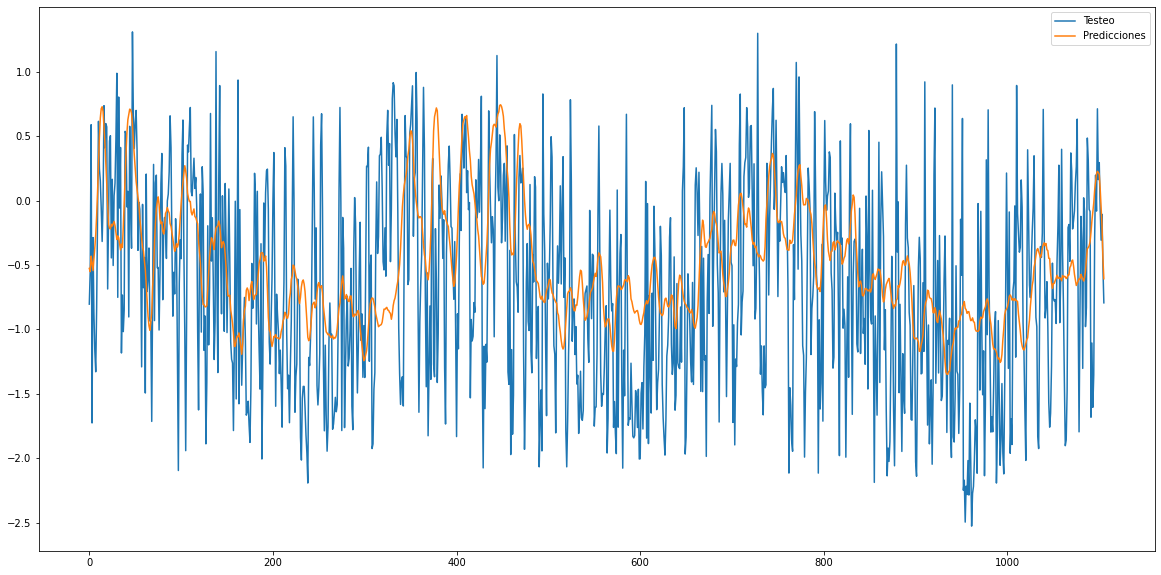

In [37]:
mse = np.nanmean((hat-test)**2)
rmse = np.sqrt(mse)
print(f"el MSE es {mse}, y el RMSE es {rmse}")

plt.figure(figsize=(20,10))
ds1 = pd.Series(hat)
ds2 = pd.Series(test)
plt.plot(ds2, label='Testeo')
plt.plot(ds1, label='Predicciones')
plt.legend()
plt.show()

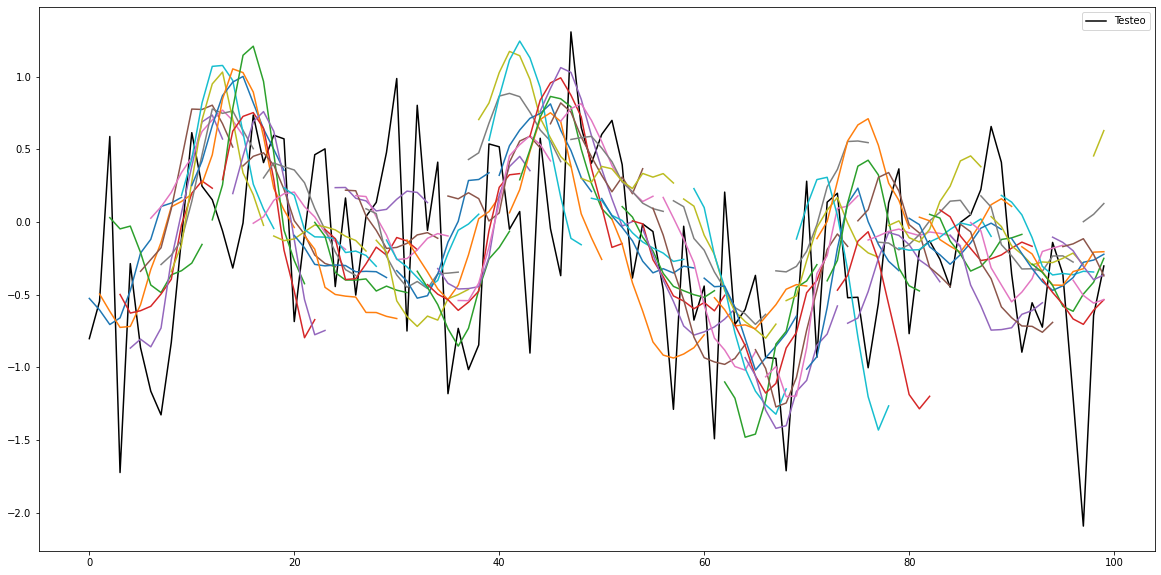

In [38]:
def unpack_yhat_matrix(yhat):
  hat = [[np.NaN for i in range(len(yhat))] for j in range(len(yhat))]
  i = 0
  while i < (len(yhat)-10-1):
    hat[i][i:i+10] = yhat[i]
    i += 1
  return (hat)

hat_mat = unpack_yhat_matrix(yhat)

plt.figure(figsize=(20,10))
ds2 = pd.Series(test[0:100])
plt.plot(ds2, label='Testeo', c='black')
for i in range(100):
  plt.plot(hat_mat[i][0:100])
plt.legend()
plt.show()